In [13]:
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetRDKitFPGenerator

# Load a molecule from SMILES
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kav_mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)

# Create the RDKit fingerprint generator with maxPath=5 and fpSize=2048
fpgen = GetRDKitFPGenerator(maxPath=6, fpSize=2048)

# Generate the fingerprint
fp = fpgen.GetFingerprint(Kav_mol)
print(fp.ToBitString())  # Print the binary fingerprint


0111000000001000010011011011000111100000001000001010001010010100100010110010110000000010001010001100010000100100100000000111000001000110001010000000100100001001000000100111011000011000011000010100001010111100110110000100000000001100011000010100001001010100100001011000100010000000101000110000010101000001110010011000011011010000011000001101000000000000001100000100000000001000000000000000100100010001001100010000111000101010000000110001000110110000000000010001001001000100000100000000100000010001010111000110011001000000000001001000100000000100000010001000010000100000110000000000100000000000000011010101000000101001101101100000111000010110000010000011110101100000011000100010000111010000110101100010001000011110100001000011001010100100010100010011001000110000110011101001100000100100100000100100100001110000100001000011001011101100000000101000001110100000101100000000001100010001000010100000001010000010100011100100001101101000011001000001110100001000100001100100000011110101001000100000000001010001

In [14]:
def isomeric_to_canonical_smiles(isomeric_smiles):

    mol = Chem.MolFromSmiles(isomeric_smiles)
    Chem.RemoveStereochemistry( mol ) 

    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    
    return canonical_smiles

Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_SMILES = isomeric_to_canonical_smiles(Kavaratamide_A_SMILES)
s_old = "CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC"
s_new = "CCCCCCC(O)CC(=O)NC1CCOC1=O"

Kav_mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
s_old_mol = Chem.MolFromSmiles(s_old)
s_new_mol = Chem.MolFromSmiles(s_new)

In [15]:
from math import sqrt
import torch, numpy as np

def set_based_cosine(x,y):
    '''x, y are same shape array'''
    a = set(x)
    b = set(y)
    return (len(a&b))/(sqrt(len(a))*sqrt(len(b)))


def compute_cos_sim(fp1, fp2):
    fp1 = fp1.float()
    fp2 = fp2.float()
    return (fp1 @ fp2) / (torch.norm(fp1) * torch.norm(fp2)).item()



In [16]:


FP_kav = torch.tensor(fpgen.GetFingerprint(Kav_mol))
FP_s_new = torch.tensor(fpgen.GetFingerprint(s_new_mol))
FP_s_old = torch.tensor(fpgen.GetFingerprint(s_old_mol))
    
# print(f"cosine similarity between Kavaratamide_A and s_new: {compute_cos_sim(morganFP_kav, morganFP_s_new)}")
# print(f"cosine similarity between Kavaratamide_A and s_old: {compute_cos_sim(morganFP_kav, morganFP_s_old)}")

# print(f"IoU between Kavaratamide_A FP and s_new FP: {torch.sum(morganFP_kav & morganFP_s_new) / torch.sum(morganFP_kav | morganFP_s_new)}")
# print(f"IoU between Kavaratamide_A FP and s_old FP: {torch.sum(morganFP_kav & morganFP_s_old) / torch.sum(morganFP_kav | morganFP_s_old)}")

print(f"cosine similarity between Kavaratamide_A and s_new: {compute_cos_sim(FP_kav, FP_s_new)}")
print(f"cosine similarity between Kavaratamide_A and s_old: {compute_cos_sim(FP_kav, FP_s_old)}")
print(f"IoU between Kavaratamide_A FP and s_new FP: {torch.sum(FP_kav & FP_s_new) / torch.sum(FP_kav | FP_s_new)}")
print(f"IoU between Kavaratamide_A FP and s_old FP: {torch.sum(FP_kav & FP_s_old) / torch.sum(FP_kav | FP_s_old)}")

cosine similarity between Kavaratamide_A and s_new: 0.6026248335838318
cosine similarity between Kavaratamide_A and s_old: 0.8475769758224487
IoU between Kavaratamide_A FP and s_new FP: 0.37707391381263733
IoU between Kavaratamide_A FP and s_old FP: 0.7338027954101562


In [17]:
from rdkit.Chem import rdFingerprintGenerator
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitPaths()
def get_frags_from_smiles(smiles):
    frag_set = set()
    mol = Chem.MolFromSmiles(smiles)
    fp = fpgen.GetFingerprint(mol, additionalOutput=ao)

    # Print the bit information
    for bit, paths in ao.GetBitPaths().items():
        # print(f"Bit {bit} is set by the following paths:")
        for path in paths:
            atoms = list(path)  # Convert to a list of atom indices
            submol = Chem.PathToSubmol(mol, atoms)  # Extract subgraph
            # print(f" - Substructure: {} (Atoms: {atoms})")
            sub_smiles = Chem.MolToSmiles(submol)
            frag_set.add(sub_smiles)
            if (sub_smiles != isomeric_to_canonical_smiles(sub_smiles)) :
                print(f" - Substructure: {sub_smiles} (Atoms: {atoms})")
            
    return frag_set       


In [18]:
kav_frags = get_frags_from_smiles(Kavaratamide_A_SMILES)
new_frags = get_frags_from_smiles(s_new)
old_frags = get_frags_from_smiles(s_old)

In [19]:
len(kav_frags), len(new_frags), len(old_frags)

(400, 143, 367)

In [20]:
kav_frags

{'C1=CCNC1',
 'C=C',
 'C=C(C)O',
 'C=C(C)OC',
 'C=C(CC)OC',
 'C=C(CCC)OC',
 'C=C(CN)OC',
 'C=C(CNC)OC',
 'C=C(O)C(C)N',
 'C=C(O)C(C)NC',
 'C=C(O)C(N)CC',
 'C=C(O)CC',
 'C=C(O)CC(C)C',
 'C=C(O)CCC',
 'C=C(O)CN',
 'C=C(O)CN(C)C',
 'C=C(O)CNC',
 'C=C(O)CNC=O',
 'C=C(O)CNCC',
 'C=C(OC)C(C)N',
 'C=CC',
 'C=CC(=O)N(C)C',
 'C=CC(=O)NC',
 'C=CC(=O)NC=O',
 'C=CC(=O)NCC',
 'C=CC(C)N',
 'C=CC(C)N(C)C',
 'C=CC(C)NC',
 'C=CC(C)NC=O',
 'C=CC(C)NCC',
 'C=CC(CC)NC',
 'C=CC(N)=O',
 'C=CC(N)C(C)C',
 'C=CC(N)CC',
 'C=CC=O',
 'C=CCC',
 'C=CCC(C)C',
 'C=CCCC',
 'C=CCN',
 'C=CCN(C)C',
 'C=CCN(C)C=O',
 'C=CCN(C)CC',
 'C=CCNC',
 'C=CCNC(C)=O',
 'C=CCNC=O',
 'C=CCNCC',
 'C=CCNCCC',
 'C=CCNCCO',
 'C=CO',
 'C=COC',
 'C=O',
 'CC',
 'CC(=O)N(C)C',
 'CC(=O)N(C)C=O',
 'CC(=O)NC(C)=O',
 'CC(=O)NC(C)C',
 'CC(=O)NC=O',
 'CC(=O)NCC=O',
 'CC(=O)NCCN',
 'CC(=O)NCCO',
 'CC(=O)O',
 'CC(=O)OC(C)C',
 'CC(=O)OCC=O',
 'CC(=O)OCCN',
 'CC(C)C',
 'CC(C)C(C)N',
 'CC(C)C(C)O',
 'CC(C)C(N)C=O',
 'CC(C)C(N)CN',
 'CC(C)C(N)CO',
 'CC(C)

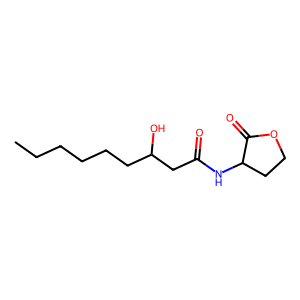

In [21]:
from rdkit.Chem import Draw

img = Draw.MolToImage(s_new_mol)
img

In [24]:
from visualize_frags import highlight_fragments, display_images


In [23]:
images = highlight_fragments(Kavaratamide_A_SMILES, kav_frags)
display_images(images, kav_frags)

In [26]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=10, fpSize=2048)

ao = rdFingerprintGenerator.AdditionalOutput()
ao.CollectBitInfoMap()


m = Chem.MolFromSmiles('c1cccnc1C')
morganFP = fpgen.GetSparseFingerprint(m, additionalOutput=ao)



In [27]:
dir(morganFP)

['FromBase64',
 'GetBit',
 'GetNumBits',
 'GetNumOffBits',
 'GetNumOnBits',
 'GetOnBits',
 'SetBit',
 'SetBitsFromList',
 'ToBase64',
 'ToBinary',
 'ToBitString',
 'ToList',
 'UnSetBit',
 'UnSetBitsFromList',
 '__and__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getinitargs__',
 '__getitem__',
 '__getstate__',
 '__getstate_manages_dict__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__instance_size__',
 '__invert__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__safe_for_unpickling__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '__xor__']

In [28]:
morganFP.GetNumOnBits()

18

In [13]:
ao.GetBitInfoMap()

{98513984: ((1, 1), (2, 1)),
 195742748: ((3, 3),),
 422715066: ((6, 1),),
 951226070: ((0, 1),),
 1100037548: ((4, 1),),
 1207774339: ((2, 2),),
 1235524787: ((0, 2),),
 1751362425: ((4, 2),),
 2041434490: ((4, 0),),
 2246728737: ((6, 0),),
 2614860224: ((3, 2),),
 3072642502: ((2, 3),),
 3217380708: ((5, 0),),
 3218693969: ((0, 0), (1, 0), (2, 0), (3, 0)),
 3776905034: ((3, 1),),
 3999906991: ((1, 2),),
 4036277955: ((5, 1),),
 4048591891: ((5, 2),)}

In [16]:
help(SparseBitVect)

NameError: name 'SparseBitVect' is not defined